In [1]:
%load_ext autoreload
%autoreload 2

from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import proplot as pplt
import sys
sys.path.append('../reference')
from tqdm import tqdm

# Importing key functions from xview3 reference metric package
from metric import compute_loc_performance, calculate_p_r_f, drop_low_confidence_preds
from utils import plot_perf_vs_size, plot_size_hist

## Running Initial Data Processing

In [2]:
# Set key parameters
source_key = 'ais'
region_key = 'all'

## DON'T CHANGE ANYTHING BELOW THIS LINE ##
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

region_dict = {'adriatic':  ['adriatic'],
           'iceland-norway': ['iceland-norway'],
           'gulf-of-guinea': ['gulf-of-guinea'],
           'all': ['iceland-norway','gulf-of-guinea', 'adriatic']
          }
regions = region_dict[region_key]

source_dict = {
    'all':['ais', 'ais/manual', 'manual'],
    'ais':['ais'],
    'ais/manual':['ais/manual'],
    'manual':['manual']   
}
sources = source_dict[source_key]

today = date.today().strftime('%m-%d-%y')
drop_low_detect = True
score_all = False
distance_tolerance=200
costly_dist=True
save_loc = 'figs-and-data'

In [3]:
# Loading up dataframes from each region in the area of interest
pred = pd.DataFrame()
gt = pd.DataFrame()

for reg in regions:
    p = pd.read_csv(f'../output-data/{reg}-predictions.csv')
    g = pd.read_csv(f'../output-data/{reg}-labels.csv')
    pred = pd.concat((pred,p))
    gt = pd.concat((gt, g))
gt = gt.reset_index()
pred = pred.reset_index()

In [4]:
# Dropping detects and predictions aligned with low confidence ground truth
if not score_all:
    if drop_low_detect:
        pred = drop_low_confidence_preds(pred, gt, distance_tolerance=distance_tolerance, 
                                         costly_dist=costly_dist)
    gt = gt[gt["confidence"].isin(["HIGH", "MEDIUM"])
    ].reset_index()

# Getting true positive, false positive, and false negative indices from dataframes
tp_inds, fp_inds, fn_inds = [], [], []

for scene_id in tqdm(gt["scene_id"].unique()):
    pred_sc = pred[pred["scene_id"] == scene_id]
    gt_sc = gt[gt["scene_id"] == scene_id]
    tp_inds_sc, fp_inds_sc, fn_inds_sc, = compute_loc_performance(
        pred_sc, gt_sc, distance_tolerance=distance_tolerance, costly_dist=costly_dist
    )

    tp_inds += tp_inds_sc
    fp_inds += fp_inds_sc
    fn_inds += fn_inds_sc

# Only keeping ground truth from the identified source(s)
if source_key != 'all':
    tp_inds = [x for x in tp_inds if gt.iloc[x['gt_idx']]['source'] in sources]
    fn_inds = [x for x in fn_inds if gt.iloc[x]['source'] in sources]

# Computing precision, recall, f1
precision_dict = {}
recall_dict = {}
f1_dict = {}
pr, re, f1 = calculate_p_r_f(tp_inds, fp_inds, fn_inds)
precision_dict[f'{region_key}-{source_key}'] = pr
recall_dict[f'{region_key}-{source_key}'] = re
f1_dict[f'{region_key}-{source_key}'] = f1

100%|██████████| 237/237 [00:09<00:00, 24.84it/s]


In [5]:
# Get size buckets for detections
tp_t = {}
fp_t = {}
fn_t = {}
p_r_f = {}

size_buckets = list(range(0,301,20))+[500]
for sz in range(len(size_buckets)-1):
    low_bound = size_buckets[sz] 
    up_bound = size_buckets[sz+1]
    tp_t[low_bound] = [x for x in tp_inds if low_bound < gt.iloc[x['gt_idx']]['vessel_length_m'] <= up_bound]
    fp_t[low_bound] = [x for x in fp_inds if low_bound < pred.iloc[x]['vessel_length_m'] <= up_bound]
    fn_t[low_bound] = [x for x in fn_inds if low_bound < gt.iloc[x]['vessel_length_m'] <= up_bound]
    p_r_f[low_bound] = calculate_p_r_f(tp_t[low_bound], fp_t[low_bound], fn_t[low_bound])

In [6]:
# Get number of ground truth by size
sizes = list(size_buckets[0:-1])
nums = {}
for sz in sizes:
    nums[sz] = len(tp_t[sz]) + len(fn_t[sz])

In [7]:
# Create unique string for this analysis
title_string = f"{'-'.join(regions)}-{source_key}-drop_low_detect-{drop_low_detect}-{today}".replace('/','_')

In [8]:
# Pickle the data
data_dict = {}
data_dict['f1'] = f1
data_dict['precision'] = pr
data_dict['recall'] = re
data_dict['perf_by_size'] = p_r_f
data_dict['size_buckets'] = size_buckets
data_dict['sizes'] = sizes
data_dict['nums'] = nums
with open(f'{save_loc}/{title_string}-data.pkl','wb') as fl:
    pickle.dump(data_dict, fl)

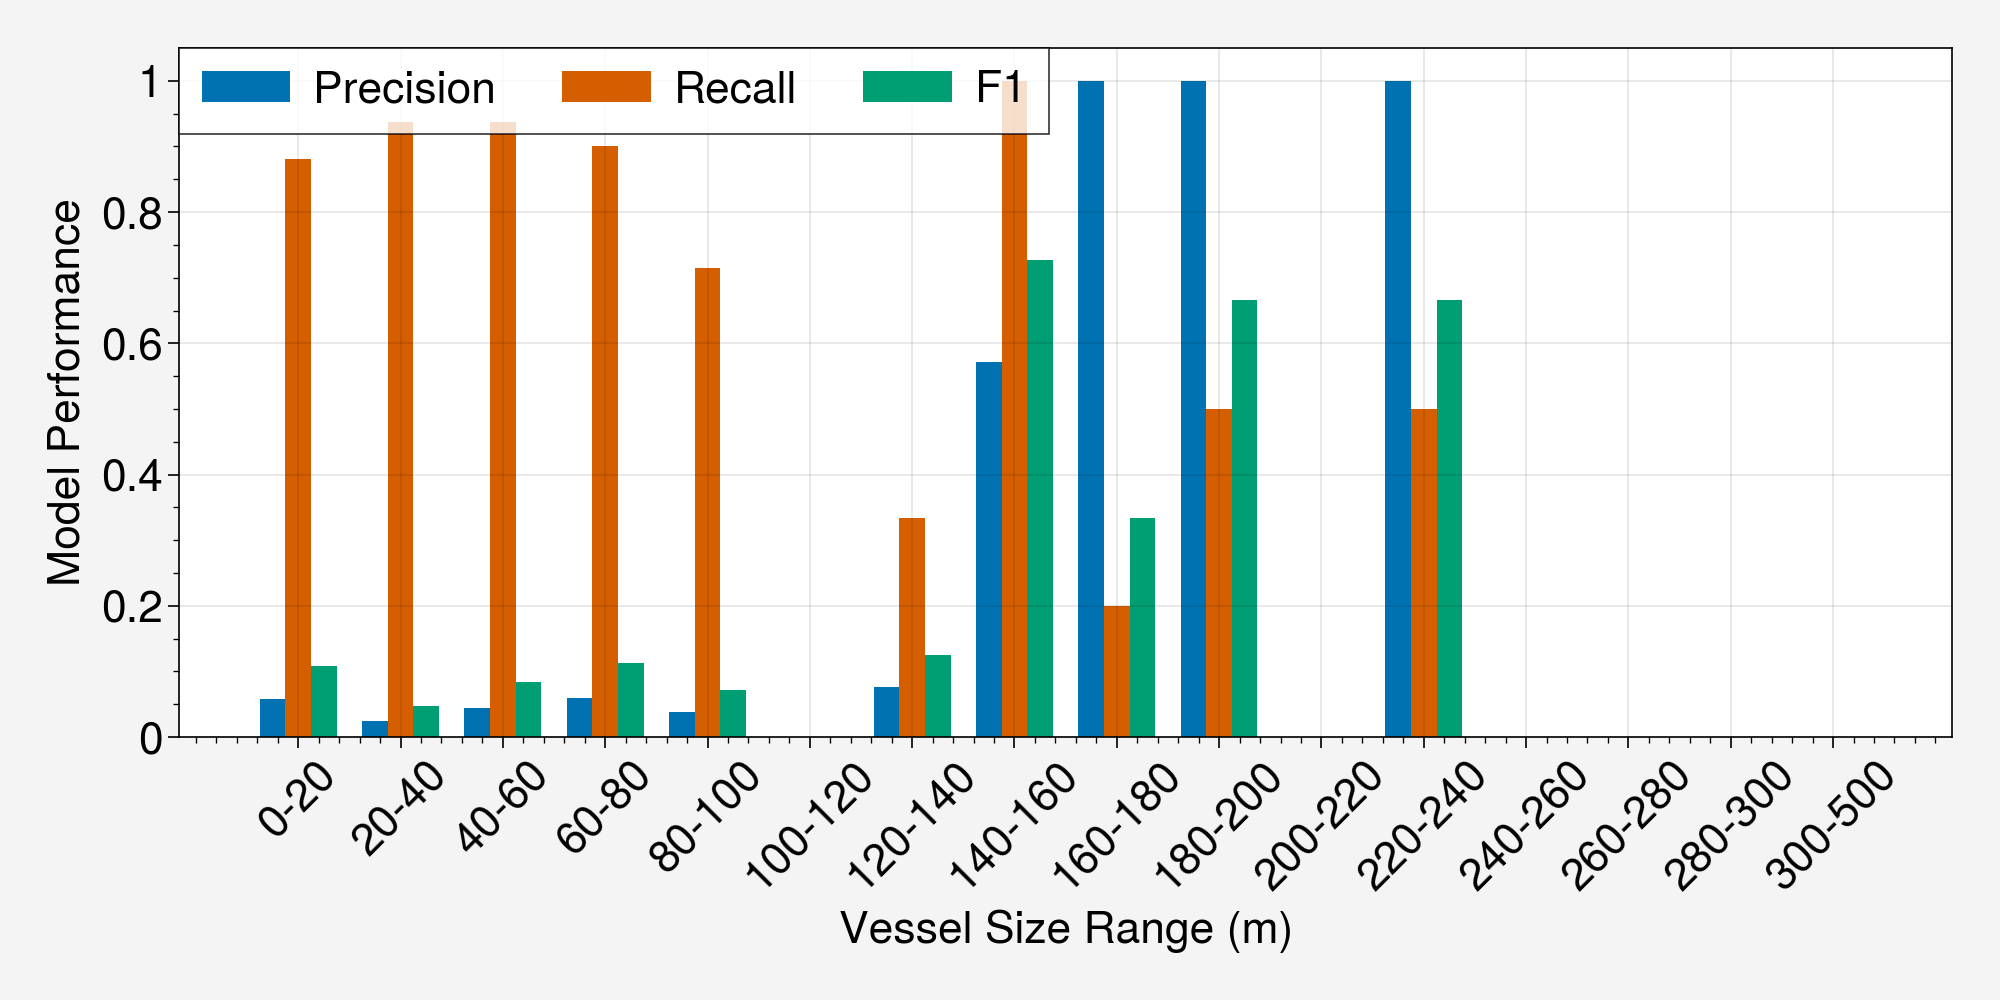

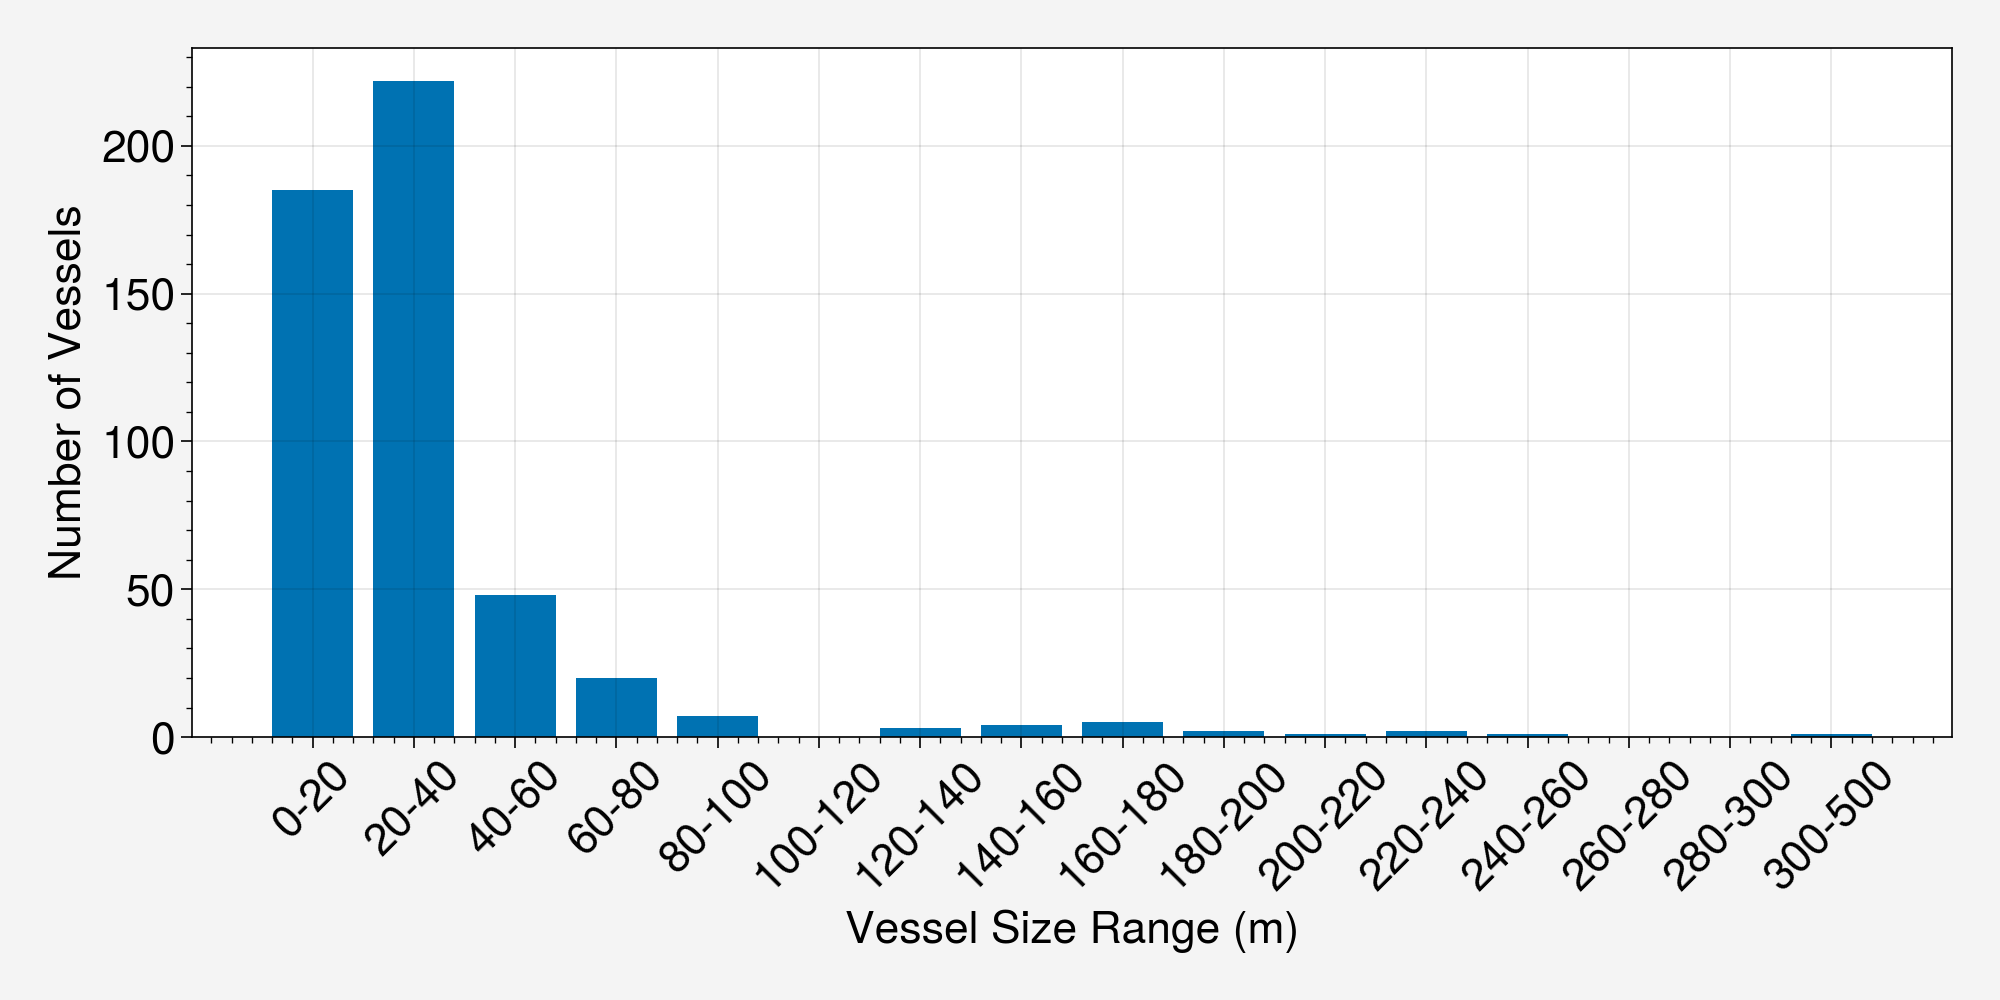

In [9]:
# Plot size graph
plot_perf_vs_size(size_buckets, p_r_f, title_string, save_loc=save_loc)
plot_size_hist(size_buckets, nums, title_string, save_loc=save_loc)

## Plotting

In [10]:
#id_string = f"{'-'.join(regions)}-{source_key}-drop_low_detect-{drop_low_detect}-{today}".replace('/','_')
#with open(f'{save_loc}/{title_string}-data.pkl','rb') as fl:
#    ldt = pickle.load(fl)

In [11]:
#plot_perf_vs_size(ldt['size_buckets'], ldt['perf_by_size'], title_string, save_loc=None)
#plot_size_hist(ldt['nums'], title_string, save_loc=None)

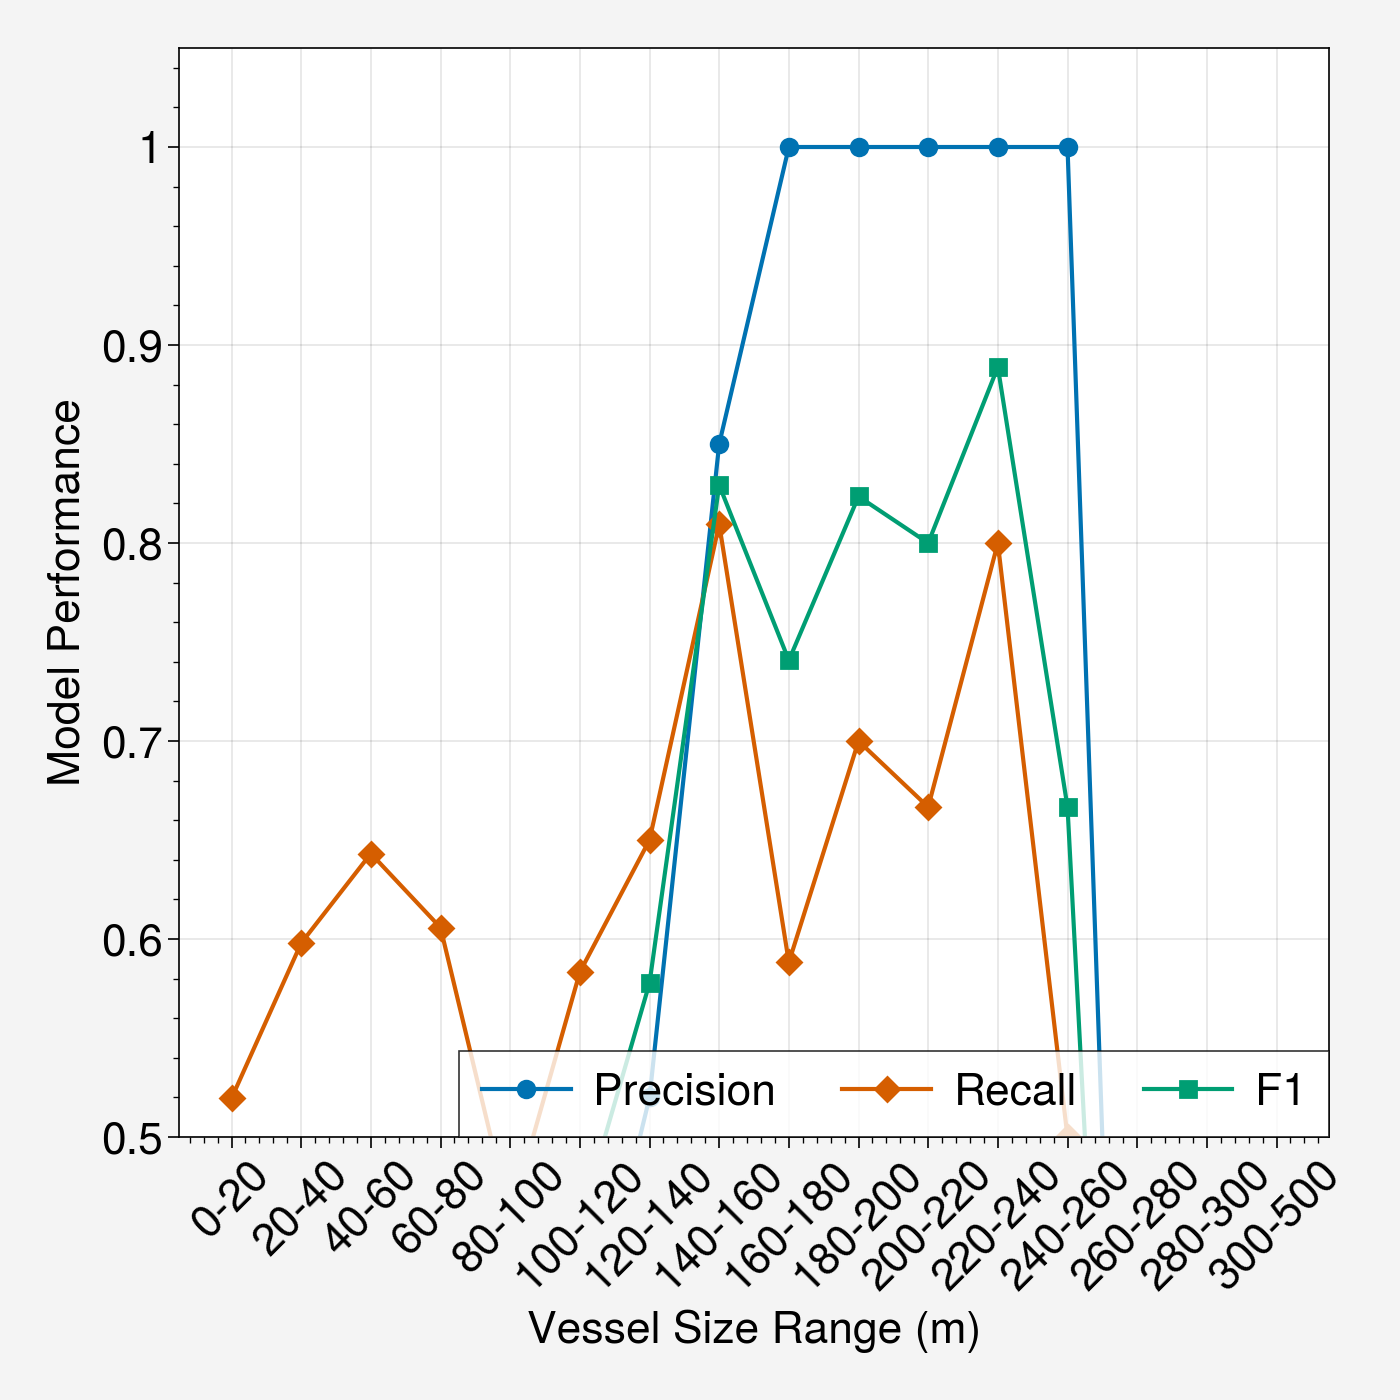

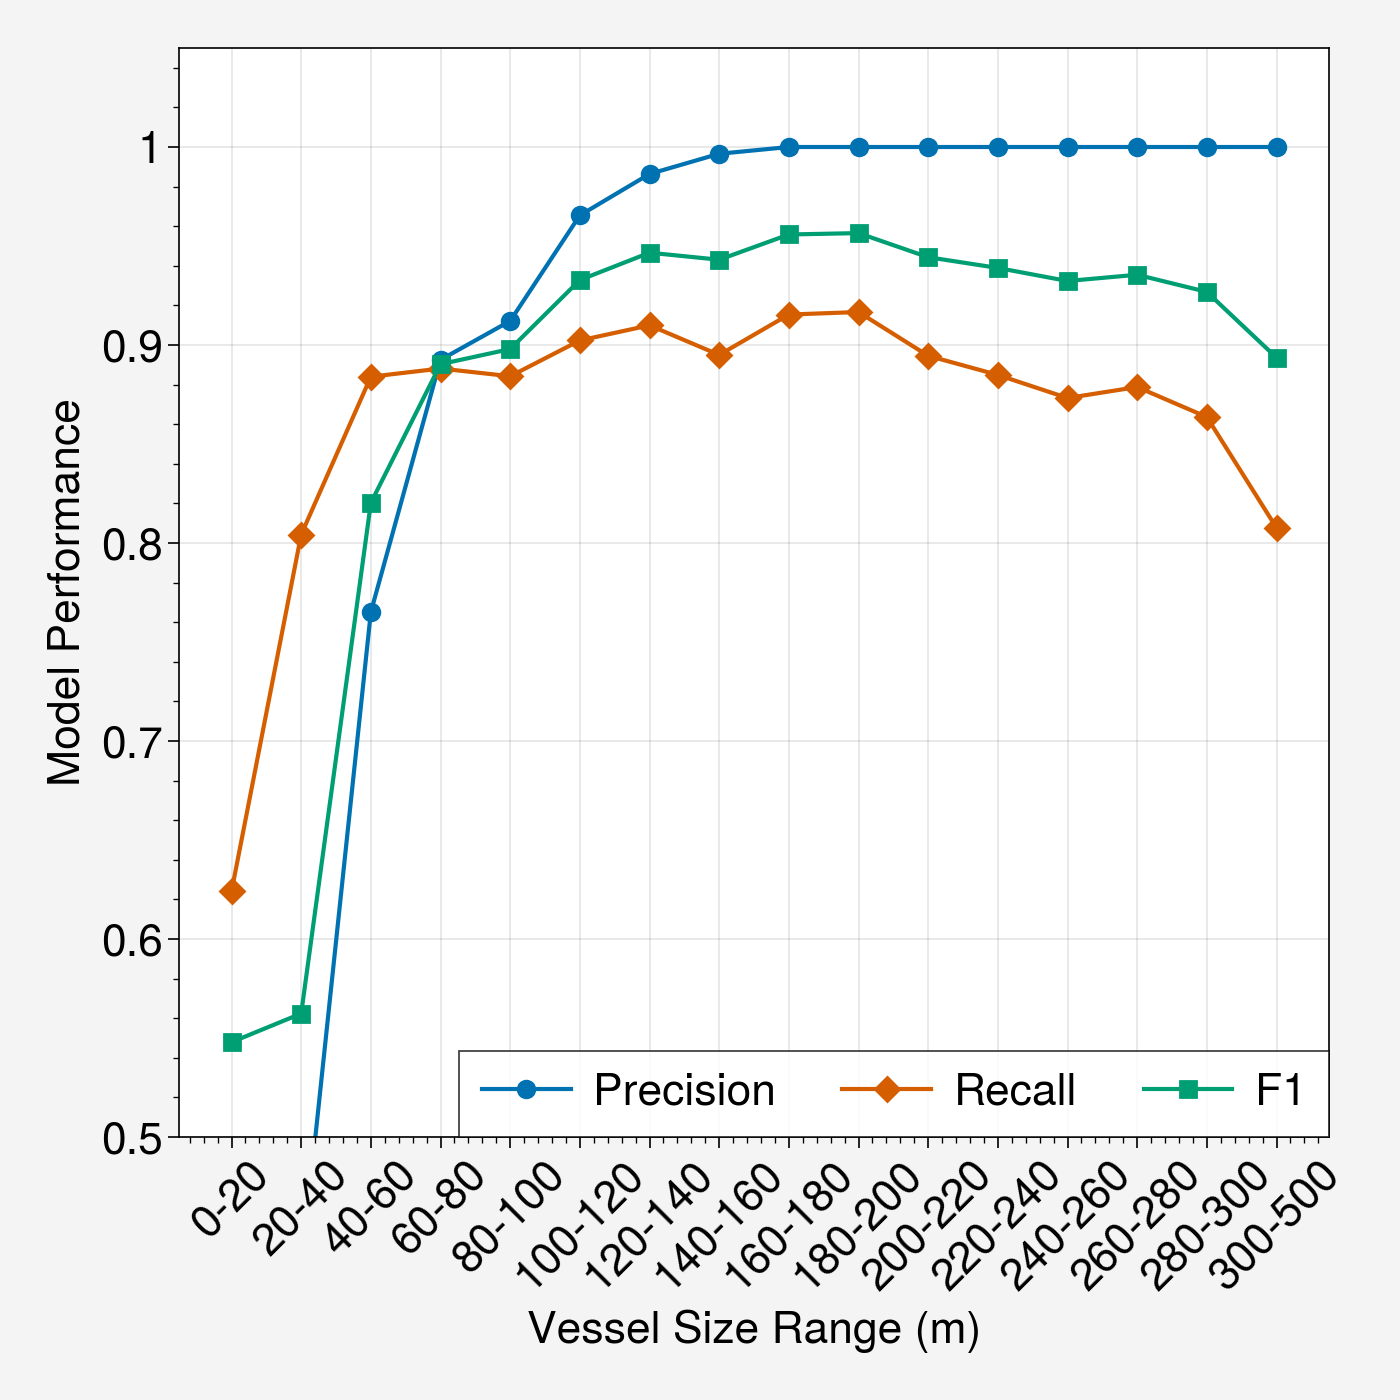

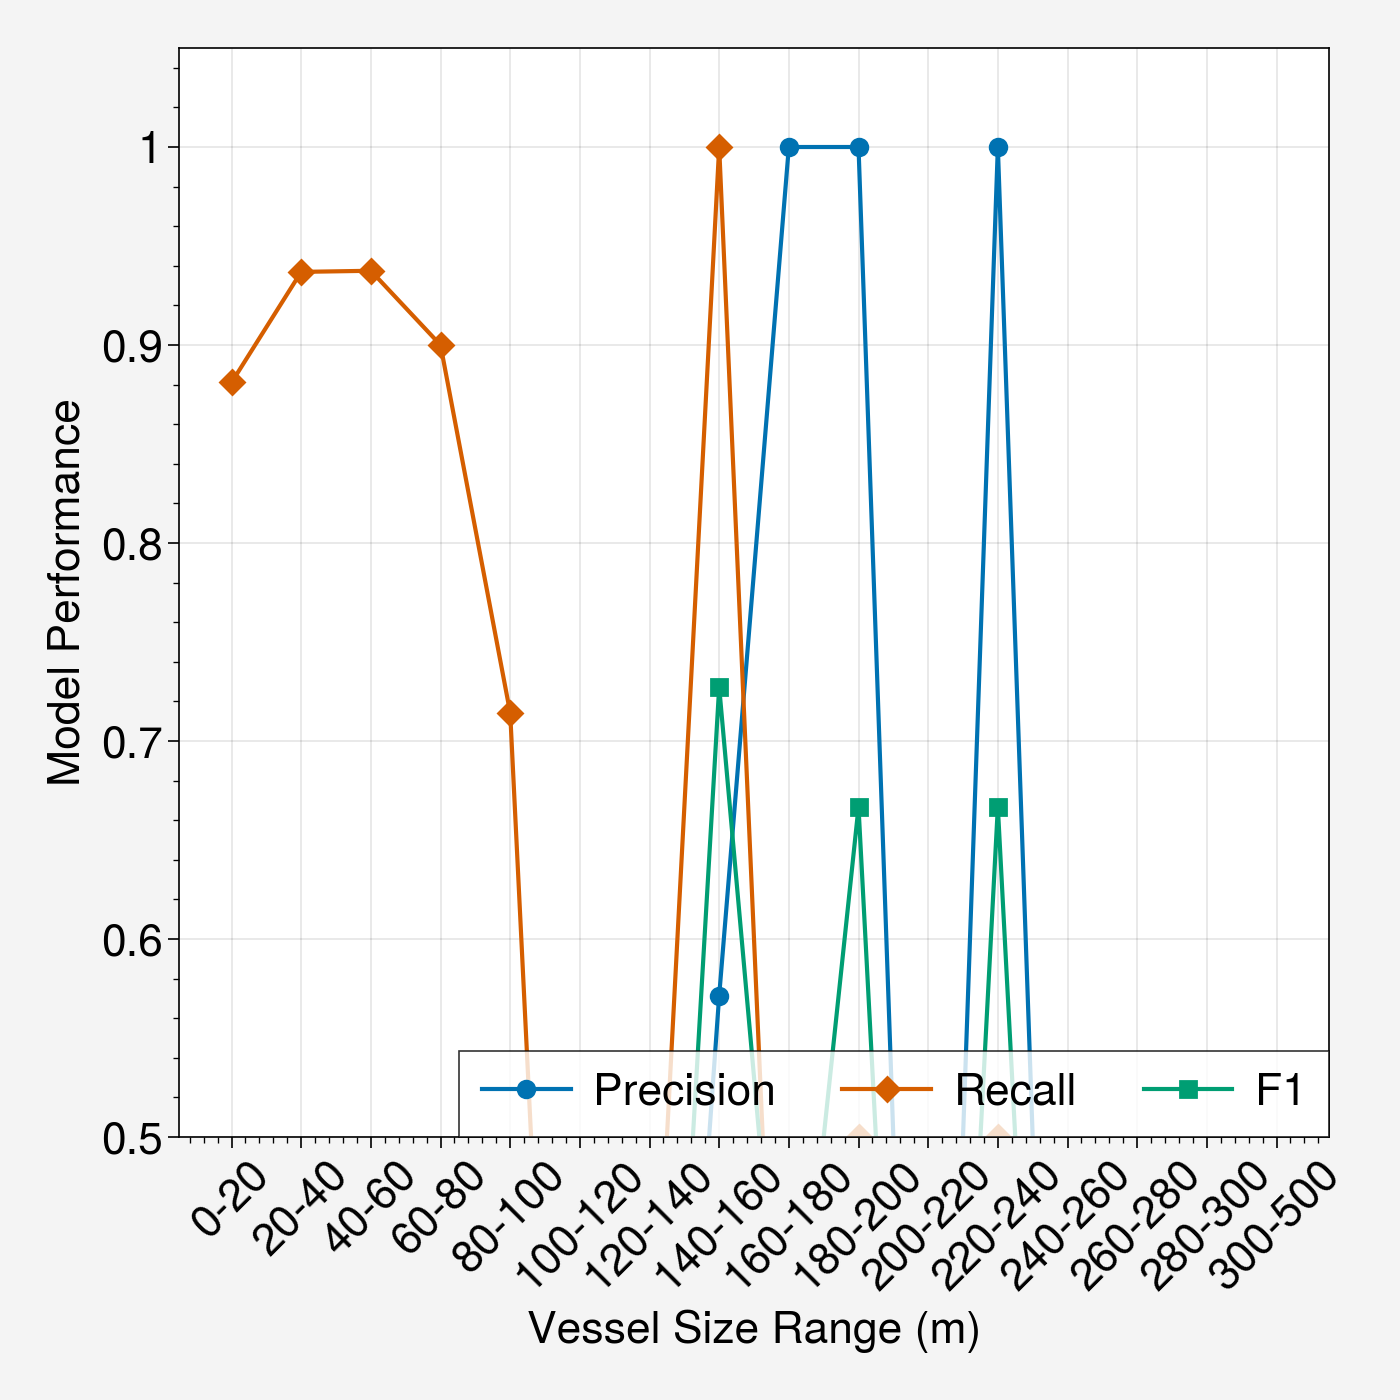

In [50]:
#plot_regions = ['all', 'adriatic', 'gulf-of-guinea', 'iceland-norway']
plot_regions = ['all']
plot_sources = ['manual', 'ais/manual', 'ais']
results_dict = {}
for region_ky in plot_regions:
    for source_ky in plot_sources:
        id_string = f"{'-'.join(region_dict[region_ky])}-{source_ky}-drop_low_detect-{drop_low_detect}-{today}".replace('/','_')
        with open(f'{save_loc}/{id_string}-data.pkl','rb') as fl:
            results_dict[f'{region_ky}-{source_ky}'] = pickle.load(fl)
        plot_perf_vs_size_line(results_dict[f'{region_ky}-{source_ky}']['size_buckets'],
                  results_dict[f'{region_ky}-{source_ky}']['perf_by_size'], id_string+'-line',
                               save_loc=save_loc)
        
        

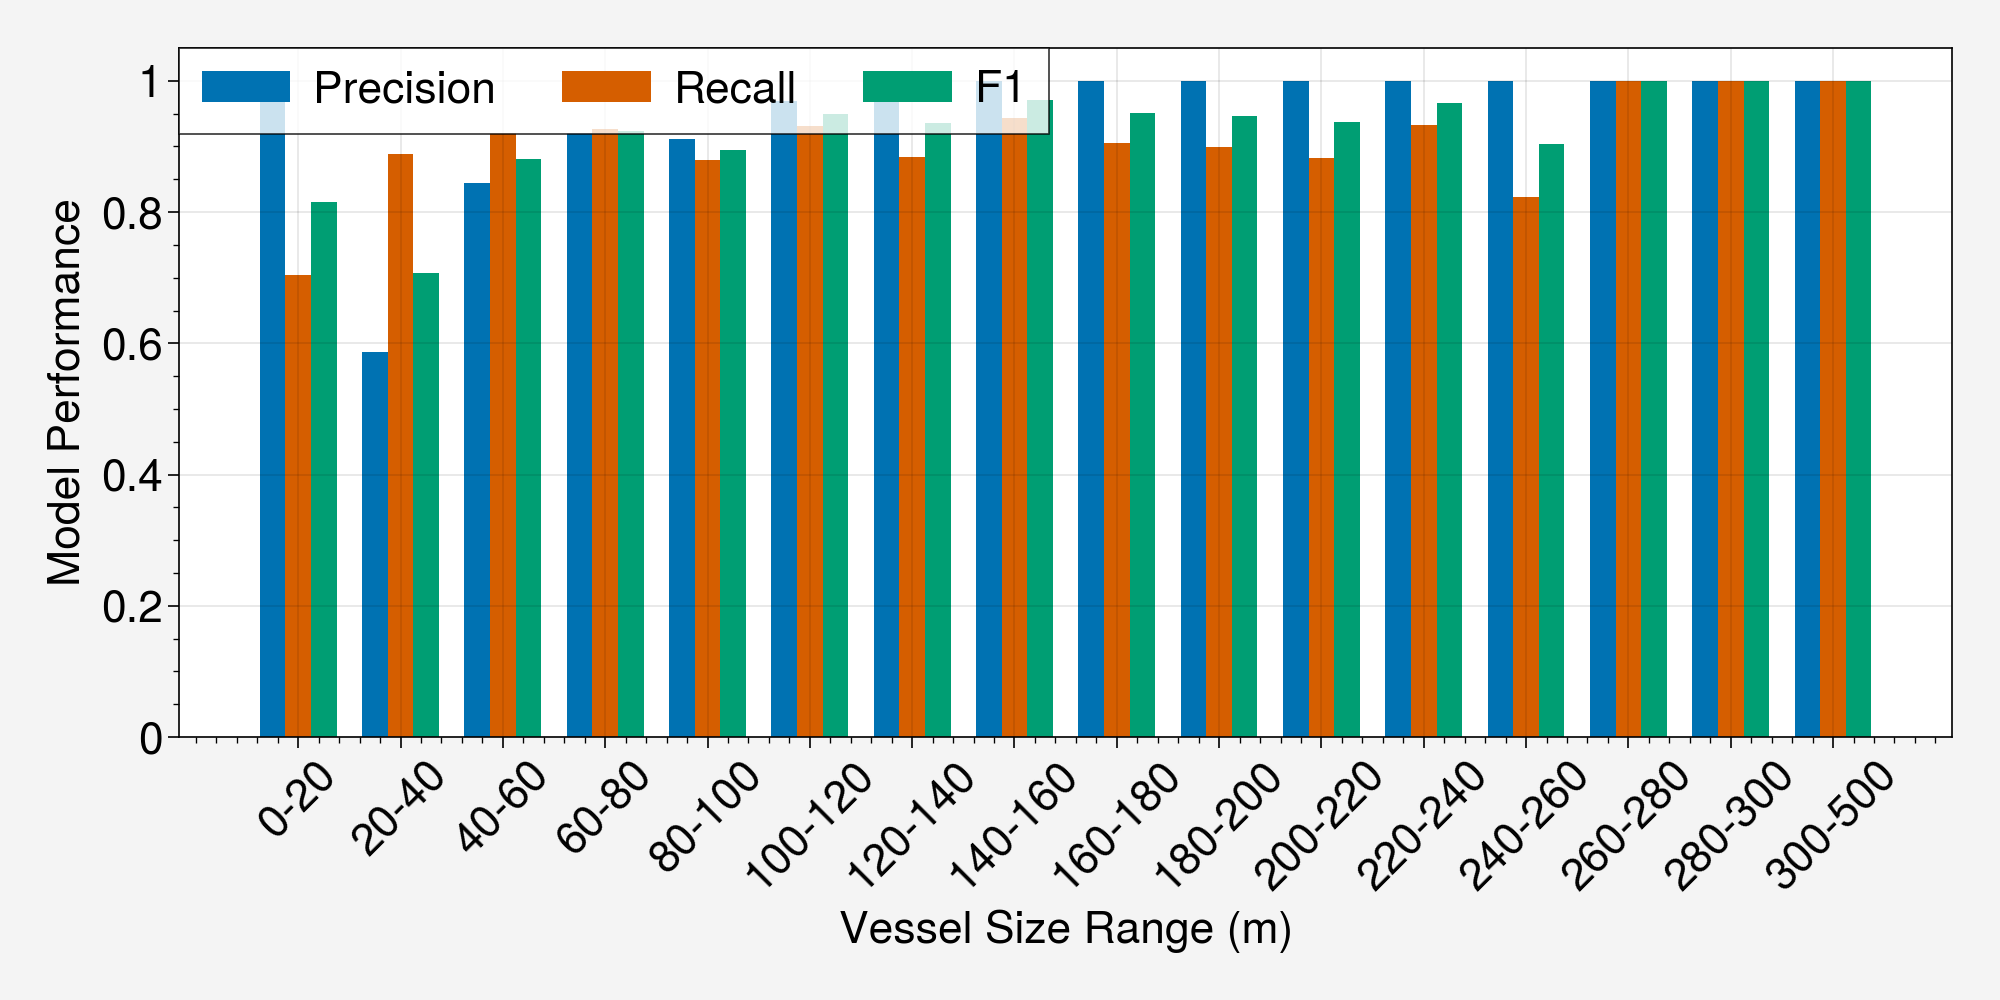

In [42]:
region_ky = 'gulf-of-guinea'
source_ky = 'all'
plot_perf_vs_size(results_dict[f'{region_ky}-{source_ky}']['size_buckets'],
                  results_dict[f'{region_ky}-{source_ky}']['perf_by_size'], id_string+'-line', 
                  save_loc=No)

In [47]:
def plot_perf_vs_size_line(szs, prf, ttl, save_loc=None):
    sizes = list(szs[0:-1])
    precs = [prf[ky][0] for ky in sizes]
    recs = [prf[ky][1] for ky in sizes]
    f1s = [prf[ky][2] for ky in sizes]

    fig = plt.figure(figsize=(7,7))
    N = len(sizes)
    ind = np.arange(N) 
    
    plt1=plt.plot(ind, precs, marker='o')
    plt2=plt.plot(ind, recs, marker='D')
    plt3=plt.plot(ind, f1s, marker='s')

    plt.ylabel('Model Performance')
    plt.xlabel("Vessel Size Range (m)")

    plt.ylim((0.5,1.05))

    plt.xticks(ind, [f'{szs[s]}-{szs[s+1]}' for s in range(len(sizes))], rotation=45)
    plt.legend( ('Precision','Recall','F1'), ncol=3, loc="lower right" )
    plt.tight_layout()
    if save_loc is not None:
        plt.savefig(f'{save_loc}/Performance-Vs-Size-{ttl}.jpg')

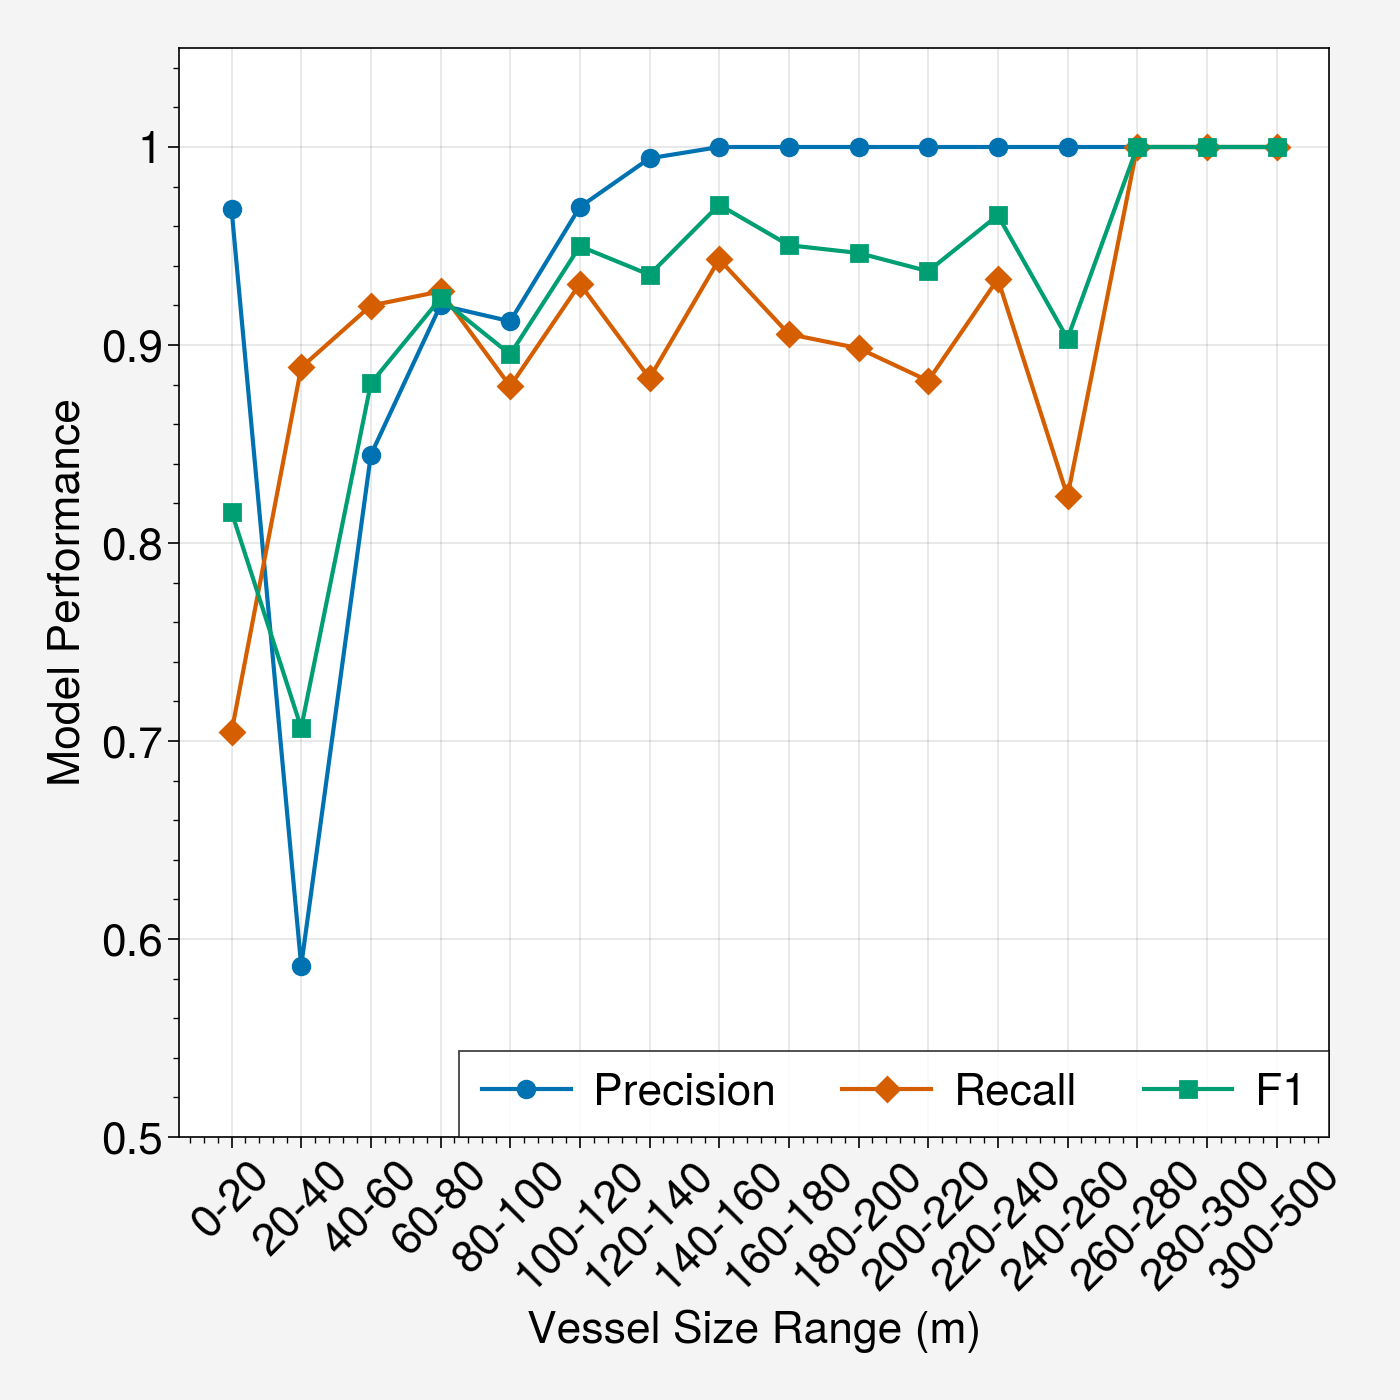

In [48]:
plot_perf_vs_size_line(results_dict[f'{region_ky}-{source_ky}']['size_buckets'],
                  results_dict[f'{region_ky}-{source_ky}']['perf_by_size'], title_string, save_loc=None)